## Predicting the value of players


#### Problem statement
Can we identify which players are over or undervalued?

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [9]:
df = pd.read_csv("data/1. processed/data_clean.csv")

df = df.loc[df['value_clean']!=0].copy() #delete rows with 0 in value_clean column

## EDA

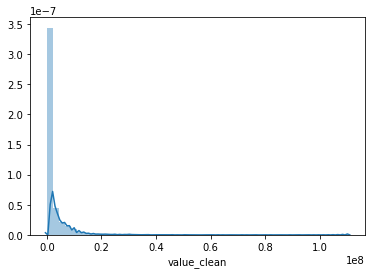

In [10]:
sns.distplot(df['value_clean'])
plt.show()

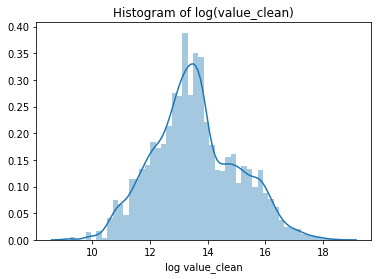

In [11]:
sns.distplot(np.log(df['value_clean']))
plt.title("Histogram of log(value_clean)")
plt.xlabel("log value_clean")
plt.show()

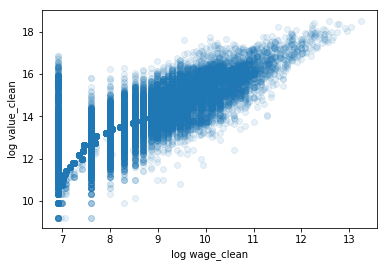

In [12]:
plt.scatter(x=np.log(df['wage_clean']),y=np.log(df['value_clean']),alpha=0.1)
plt.xlabel("log wage_clean")
plt.ylabel("log value_clean")
plt.show()

__Outlier detection__

calculate Cook's distances for linear regression [link](http://mpastell.com/2013/04/19/python_regression/)